# The sum of the enhancer strengths per gene correlated well with gene expression levels on average

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
meta_df = pd.read_csv("/data5/deepro/starrseq/papers/results/1_categorize_fragments_on_activity/data/meta_activity_map.csv")

In [3]:
def get_enhancer_to_gene_maps(filename):
    df = pd.read_csv(filename, sep="\t")
    df["enhancer_id"] = df.chr + "_" + df.start.astype(str) + "_" + df.end.astype(str)
    return df.loc[:, ["enhancer_id", "TargetGene"]]

def get_tpm_normalized_gene_expression(filename):
    df = pd.read_csv(filename, sep="\t", index_col=[0, 1], skipfooter=5, engine="python")
    df = (df*1e6/df.sum()).mean(axis=1)
    return df

def get_meta_gene_exp_df(store_dir, ko_lines):
    df_list = []
    for ko in ko_lines:
        exp_file = os.path.join(store_dir, ko, "counts.tsv")
        exp_df = get_tpm_normalized_gene_expression(exp_file)
        df_list.append(exp_df)
    exp_df = pd.concat(df_list, axis=1)
    exp_df.columns = ko_lines
    return exp_df.reset_index()

def add_enhancer_activity(enhancer_mapped_df, meta_df):
    df = enhancer_mapped_df.merge(meta_df, left_on="enhancer_id", right_on="chrom_coord")
    return df.loc[:, ['enhancer_id', 'TargetGene', 'chrom_coord', 'CC', 'ATF2', 'CTCF', 'FOXA1', 'LEF1', 'SCRT1', 'TCF7L2', '16P12_1']]

In [4]:
ko_lines = ["CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]
store_dir = "/data5/deepro/starrseq/papers/results/4_compare_expression_ko_vs_wt/data/results/count/"

In [5]:
exp_df = get_meta_gene_exp_df(store_dir, ko_lines)

In [6]:
prediction_types = ["activity_from_chip_nohic", "activity_from_chip_with_hic", "activity_from_starr_nohic", "activity_from_starr_with_hic"]

for pt in prediction_types:
    enhancer_mapped_file = os.path.join(f"/data5/deepro/starrseq/papers/results/5_link_da_enhancers_to_de_genes/data/predictions/{pt}/EnhancerPredictionsFull.txt")
    enhancer_mapped_df = get_enhancer_to_gene_maps(enhancer_mapped_file)
    enhancer_mapped_with_activity = add_enhancer_activity(enhancer_mapped_df, meta_df)
    enhancer_mapped_with_activity_with_expression = enhancer_mapped_with_activity.merge(exp_df, left_on="TargetGene", right_on="gene_id", suffixes=("_act", "_exp"))    
    gene_with_enhancer_df = enhancer_mapped_with_activity_with_expression.groupby(
        ["TargetGene", "gene_id", "gene_name", "CC_exp", 
        "ATF2_exp", "CTCF_exp", "FOXA1_exp", "LEF1_exp", 
        "SCRT1_exp", "TCF7L2_exp",	"16P12_1_exp"]).aggregate(
        {"enhancer_id": lambda x: ",".join(x),
        "chrom_coord": lambda x: ",".join(x), 
        "CC_act": np.sum, 
        "ATF2_act": np.sum,
        "CTCF_act": np.sum, 
        "FOXA1_act": np.sum, 
        "LEF1_act": np.sum, 
        "SCRT1_act": np.sum, 
        "TCF7L2_act": np.sum,
        "16P12_1_act": np.sum 
        }).reset_index()
    expression_df = gene_with_enhancer_df.melt(id_vars=["enhancer_id", "gene_id", "gene_name"], value_vars=['CC_exp', 'ATF2_exp', 'CTCF_exp', 'FOXA1_exp', 'LEF1_exp', 'SCRT1_exp', 'TCF7L2_exp', '16P12_1_exp'], value_name="exp", var_name="ko")
    activity_df = gene_with_enhancer_df.melt(id_vars=["enhancer_id", "gene_id", "gene_name"], value_vars=['CC_act', 'ATF2_act', 'CTCF_act', 'FOXA1_act', 'LEF1_act', 'SCRT1_act', 'TCF7L2_act', '16P12_1_act'], value_name="act", var_name="ko")
    print(pt)
    print(activity_df.act.corr(expression_df.exp))

activity_from_chip_nohic
-0.0007132011680875336
activity_from_chip_with_hic
-0.011343843720973574
activity_from_starr_nohic
-0.007176064629292069
activity_from_starr_with_hic
0.0035361997419982865


In [8]:
import seaborn as sns

<AxesSubplot:xlabel='act', ylabel='exp'>

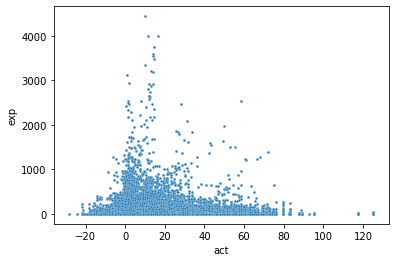

In [14]:
sns.scatterplot(x=activity_df.act, y=expression_df.exp, s=7.5)